# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [35]:
import lightgbm
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import holidays

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from Data.load_data import get_energy_data
from helper_functions import create_error_metrics

## Model Selection

We want to make a regression for energy demand in germany. This task can be achieved by using gradient boosting models. They have some advantages and disadvantages (taken from [neptune.ai](https://neptune.ai/blog/gradient-boosted-decision-trees-guide))

> #### Advantages of gradient boosting trees
>- generally more accurate compare to other modes,
>- train faster especially on larger datasets,
>- most of them provide support handling categorical features,
>- some of them handle missing values natively.

> #### Disadvantages of gradient boosting trees
>- prone to overfitting: this can be solved by applying L1 and L2 regularization penalties. You can try a low learning rate as well;
>- models can be computationally expensive and take a long time to train, especially on CPUs;
hard to interpret the final models.

In gradient boosting, an ensemble of weak learners (usually, decision trees) is used to improve the performance of a machine learning model. Their combined output results in better models. 
Weak learners work sequentially: Each model tries to improve on the error from the previous model. In the case of regression, the result is the average of all weak learners.

Thus, with gradient boosting models we can make a regression on energy demand and as they are described as fast training on large datasets with very good results.

## Feature Engineering

As the energy demand depends heavily on daily, weekly and yearly seasonality we need to add those features to our dataset.

In [88]:
german_holidays = holidays.country_holidays("Germany", years=[2017, 2018, 2019], subdiv="BY") + holidays.country_holidays("Germany", years=[2017, 2018, 2019], subdiv="SH")
german_holidays

{datetime.date(2017, 1, 1): "New Year's Day", datetime.date(2017, 4, 14): 'Good Friday', datetime.date(2017, 4, 17): 'Easter Monday', datetime.date(2017, 5, 1): 'Labor Day', datetime.date(2017, 5, 25): 'Ascension Day', datetime.date(2017, 6, 5): 'Whit Monday', datetime.date(2017, 10, 3): 'German Unity Day', datetime.date(2017, 12, 25): 'Christmas Day', datetime.date(2017, 12, 26): 'Second Day of Christmas', datetime.date(2017, 10, 31): 'Reformation Day', datetime.date(2017, 1, 6): 'Epiphany', datetime.date(2017, 6, 15): 'Corpus Christi', datetime.date(2017, 8, 15): 'Assumption Day', datetime.date(2017, 11, 1): "All Saints' Day", datetime.date(2018, 1, 1): "New Year's Day", datetime.date(2018, 3, 30): 'Good Friday', datetime.date(2018, 4, 2): 'Easter Monday', datetime.date(2018, 5, 1): 'Labor Day', datetime.date(2018, 5, 10): 'Ascension Day', datetime.date(2018, 5, 21): 'Whit Monday', datetime.date(2018, 10, 3): 'German Unity Day', datetime.date(2018, 12, 25): 'Christmas Day', datetime.

In [105]:
df = get_energy_data()

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df.loc[:, 'holiday'] = ["non-holiday" if x not in german_holidays else german_holidays.get(x) for x in df.index.date]

# Feature and target variable selection
X = df[['hour', 'day_of_week', 'day', 'month', 'day_of_year', 'Temperature']]
y = df['Load']

# # Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [106]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lightgbm.LGBMRegressor()
parameters = {
    # default -1
    # larger is usually better, but overfitting speed increases
    # limit the max depth for tree model
    "max_depth": [-1, 5, 10, 20, 50],

    # default 31
    # max number of leaves in one tree
    "num_leaves": [31, 50, 100, 200],

    # default: 0.1
    # learning_rate > 0.0 Typical: 0.05
    "learning_rate": [0.05, 0.1, 0.3, 0.5],

}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 20624, number of used features: 6
[LightGBM] [Info] Start training from score 230375.116555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 20724, number of used features: 6
[LightGBM] [Info] Start training from score 230340.088653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

LGBMRegressor(learning_rate=0.3, num_leaves=200)

## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [107]:
# Implement the final model(s)
# Example: model = YourChosenModel(best_hyperparameters)
# model.fit(X_train, y_train)
grid_search.best_estimator_

LGBMRegressor(learning_rate=0.3, num_leaves=200)

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [108]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)
prediction = grid_search.predict(X_test)
# Your evaluation code here
create_error_metrics(y_test, prediction)

,MAE,MSE,RMSE,MAPE %,R2 %
0,2735.51,15708052.74,3963.34,1.24,99.03


## Graphs 

In [109]:
df_graph = pd.DataFrame()
df_graph["y_hat"] = prediction
df_graph["y"] = y_test.values
df_graph["y-y_hat"] = df_graph["y"] - df_graph["y_hat"]
df_graph.index = y_test.index

<Axes: xlabel='Date (UTC)'>

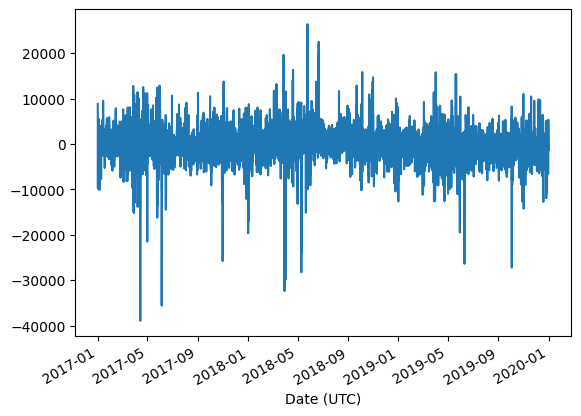

In [110]:
df_graph["y-y_hat"].plot()

<Axes: >

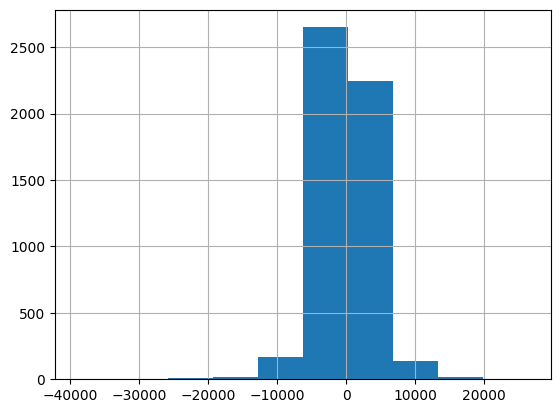

In [111]:
df_graph["y-y_hat"].hist()

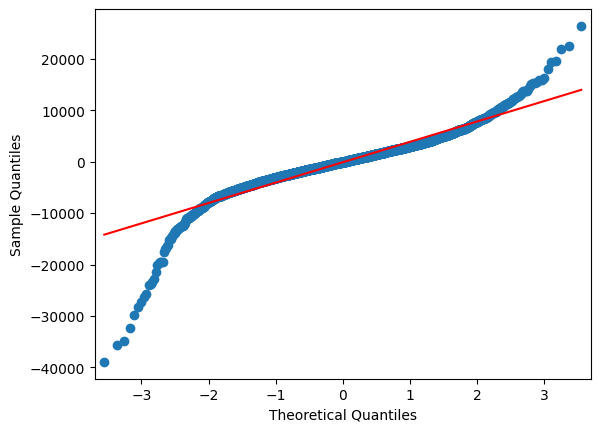

In [115]:
sm.qqplot(df_graph['y-y_hat'], line='s')
plt.show()

In [113]:
df_graph['y-y_hat']

Date (UTC)
2018-07-10 13:00:00+00:00   -2930.914976
2018-02-15 10:00:00+00:00    6382.960345
2018-10-24 00:00:00+00:00    3971.443634
2019-08-08 01:00:00+00:00    -182.009262
2017-07-29 17:00:00+00:00   -5112.036772
                                ...     
2019-03-27 01:00:00+00:00     903.631350
2017-01-07 03:00:00+00:00     715.007013
2019-11-03 13:00:00+00:00   -1862.311708
2018-11-29 12:00:00+00:00    1155.119413
2019-01-27 08:00:00+00:00    3156.478008
Name: y-y_hat, Length: 5256, dtype: float64

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [15]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
